# <center>Image Matting
Передний план — это ближайшая к нам часть изображения. Обычно мы можем отличать объекты переднего плана от заднего плана. С появлением глубоких сетей хотелось бы переложить эту задачу на них ради упрощения процесса.

Основное различие между семантической сегментацией и матированием изображений заключается в том, что в последнем мы хотим, чтобы вывод был чрезвычайно точным и непрерывным. Нам не совсем подходит класс пикселя, определяющий, принадлежит ли конкретный пиксель к переднему плану или к фону: для многих объектов, таких как волосы или мех, ответ будет чем-то средним. Большинство алгоритмов семантической сегментации обучаются без акцента на точность рёбер или границ объекта, поэтому эти модели не могут дать нам желаемый результат.

Начнём разбор результата со второго места по датасету Composition-1k. Мы выбрали его, поскольку текущий *state of the art* кажется просто более сложной версией *FBA Matting*. Кроме того, в этом датасете использовались данные извне, а разница в метриках составляет всего 1.2 MSE.

Запустим **FBA Matting** на реальных изображениях. Чтобы применить алгоритм *FBA Matting*, сначала нужно сгенерировать *Trimap*. В нашем примере мы будем использовать обученную **DeepLabV3** для создания маски сегментации с вероятностями принадлежности каждого пикселя к классу переднего плана. После этого мы воспользуемся рядом операций расширения, чтобы пометить пиксели границы и пиксели с низкой вероятностью переднего плана как неизвестные.

## TRIMAP
Основной задачей матирования является очень точное отделение переднего плана от фона. Таким образом, матирование не особо заботится о том, какой тип объекта представлен на изображении. Эта проблема не связана с фактической семантической сегментацией, и из-за этого многие алгоритмы матирования требуют **маски сегментации (trimap)** в качестве входных данных.

По сути, **trimap** — это грубая сегментация изображения на три типа областей: **передний план, неизвестная область, определённый фон**.

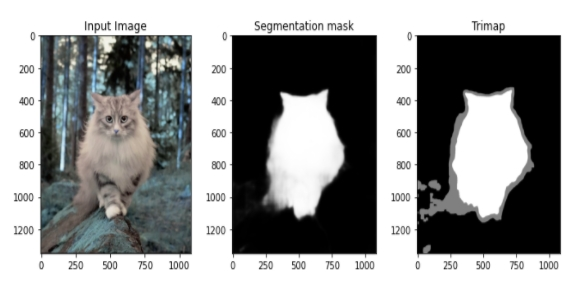

Trimap обычно объединяется с соответствующим изображением, а в качестве входных данных для модели используется четырёхканальное объединение. Однако это требование накладывает серьёзные ограничения на использование модели — нужно заранее как-то сгенерировать обрезку изображения.

Часто для запуска алгоритма матирования требуется несколько хороших обрезков, размеченных вручную. К счастью, нам не нужно этого делать — мы будем использовать сеть сегментации для прогнозирования trimap исходного изображения (именно то, что вы видели на изображении выше). Мы генерируем *trimap*, используя маску сегментации, созданную *DeepLabV3*.



## <center>ПОДХОД F, B, ALPHA MATTING
В предлагаемом методе используется энкодер-декодер-архитектура в стиле *U-Net*.

Большинство предыдущих подходов предсказывают только *Alpha Matting*, в то время как авторы статьи также предсказывают *F* и *B* непосредственно из энкодер-декодер-сети.

Другими словами, модель даёт семиканальный выход (один — для *alpha*, три — для *F* и три — для *B*).

Особые замечания от авторов статьи:
1. Три канала используются для изображения *RGB*, остальные используются для *trimap*, которая, в свою очередь, размывается Гауссом в масках переднего плана и фона в трёх различных масштабах. Такое кодирование является основным отличием от предыдущих подходов, поскольку их авторы обычно кодируют обрезку как один канал со значениями 1 для F, 0.5 для неизвестного и 0 для B.

2. *Strides* из слоя 3 и слоя 4 были удалены, а дилатация в этих слоях была увеличена до 2 и 4 соответственно. Идея заключалась в том, чтобы не допустить снижения пространственного разрешения feature map и обработать информацию в максимально возможных масштабах.

## <center>LOSS-ФУНКЦИИ
В статье используется восемь разных loss-функций:

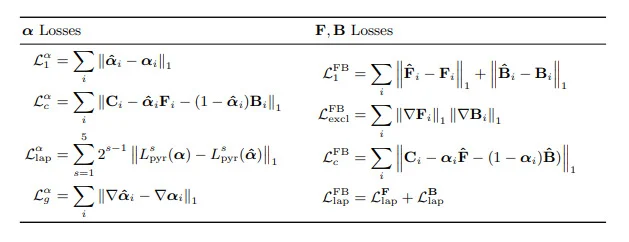

Финальный loss:



Здесь $c$ — композиционный *loss*, $g$ — градиентный, $lap$ — *loss* лапласиана на несколько скейлов, $excl$ — *loss exclusion* (исключения), который помогает обеспечить чёткое разделение между *F* и *B* и избежать просачивания структур исходного изображения в *F* и *B*.

Из статьи следует, что недостаточно рассчитать потери в зависимости только от абсолютных значений *alpha*, так как эти ошибки отчётливо не видны. Например, ошибки в форме прядей волос более заметны, чем небольшие ошибки в общем уровне непрозрачности. В примере, приведённом в ноутбуке выше (картинка с котом), видно, что низкие значения $L_1$ не гарантируют визуально привлекательных прогнозов. Вот почему использование градиентов в функции потерь очень важно, и это повод использовать потери, связанные с градиентом.

## <center>FUSION
У всех этих *loss*-функций есть проблема. Поскольку прогнозы модели *alpha*, *F*, и *B* не связаны, то связь из уравнения составления не выполняется.

Чтобы справиться с этим, авторы предложили модель слияния, основанную на оценке максимального правдоподобия:
$$ p(\alpha, F, B|\hat{\alpha}, \hat{F}, \hat{B}) $$
Предполагалась независимость используемых ошибок и игнорировалась любая пространственная зависимость между пикселями. Исходя из этого получилась вот такая модель правдоподобия — по определению *conditional independence* она пропорциональна:  
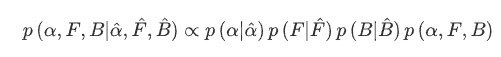  
Значения, связанные с предсказанием и *loss* реконструкции, распределяются в соответствии с распределением Гаусса:  
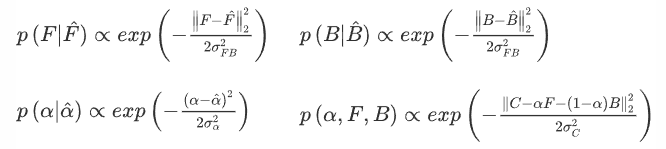  
Авторы немного упростили модель, чтобы она игнорировала пространственный *loss* (лапласиан и градиент), используя следующую схему:  
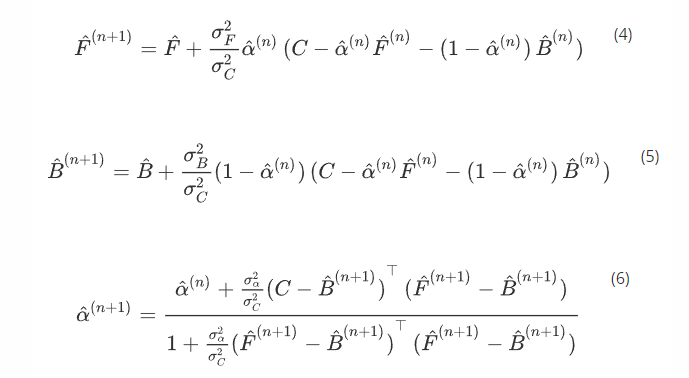

Если мы прогоним картинку с котом далее, то увидим следующий результат:

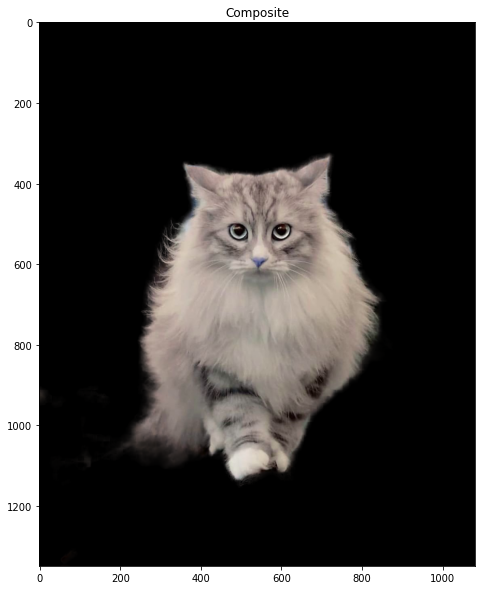